In [41]:
# import libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to disable all debugging logs

In [42]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

In [89]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/UCordoba/Machine Learning/PlantVillage/Pepper/",
                                                              seed=123,
                                                              shuffle=True,
                                                              image_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                              batch_size = BATCH_SIZE
                                                             )

Found 2459 files belonging to 2 classes.


In [90]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

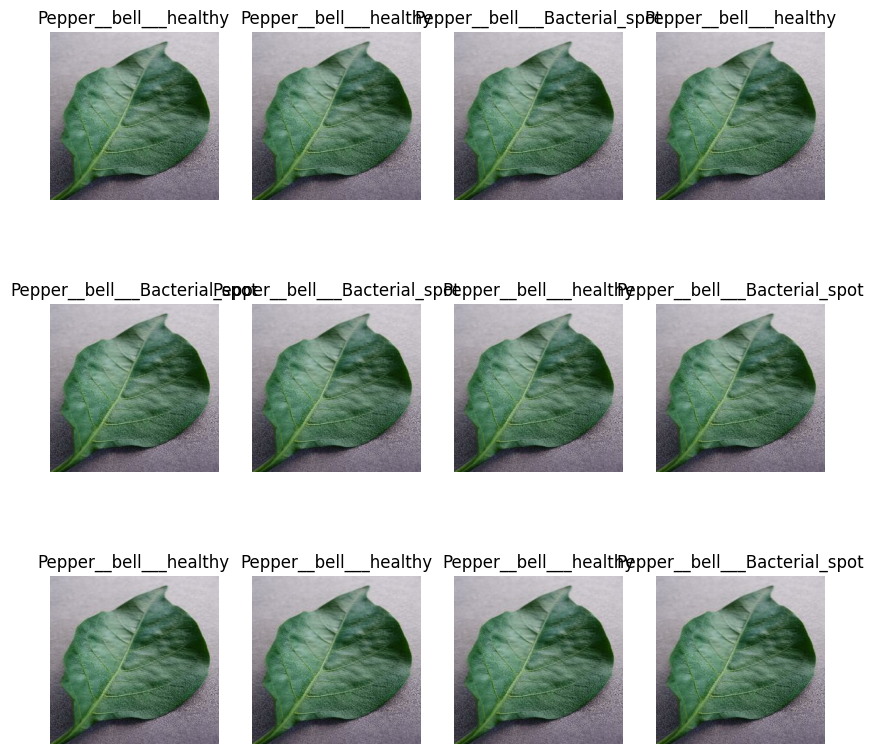

In [91]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [108]:
"""80% ==> training
20% ==> validation, 10% test"""

'80% ==> training\n20% ==> validation, 10% test'

In [109]:
train_size = 0.8
len(dataset)*train_size

61.6

In [110]:
train_ds = dataset.take(54)
len(train_ds)

54

In [111]:
test_ds = dataset.skip(54)
len(test_ds)

23

In [112]:
val_size = 0.1
len(dataset)*val_size

7.7

In [113]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [114]:
test_ds = test_ds.skip(6)
len(test_ds)

17

In [115]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [116]:
train_ds , val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [117]:
len(train_ds)

61

In [118]:
len(val_ds)

7

In [119]:
len(test_ds)

9

In [120]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [121]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [122]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [123]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [124]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [125]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (32, 60, 60, 64)        

In [126]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [128]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
61/61 [==============================] - 38s 619ms/step - loss: 0.0155 - accuracy: 0.9964 - val_loss: 0.0308 - val_accuracy: 0.9911
Epoch 2/20
61/61 [==============================] - 42s 678ms/step - loss: 0.0138 - accuracy: 0.9974 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 3/20
61/61 [==============================] - 42s 686ms/step - loss: 0.0135 - accuracy: 0.9974 - val_loss: 0.0558 - val_accuracy: 0.9866
Epoch 4/20
61/61 [==============================] - 42s 692ms/step - loss: 0.0132 - accuracy: 0.9974 - val_loss: 0.0160 - val_accuracy: 0.9955
Epoch 5/20
61/61 [==============================] - 41s 665ms/step - loss: 0.0289 - accuracy: 0.9918 - val_loss: 0.0167 - val_accuracy: 1.0000
Epoch 6/20
61/61 [==============================] - 41s 670ms/step - loss: 0.0253 - accuracy: 0.9944 - val_loss: 0.0367 - val_accuracy: 0.9821
Epoch 7/20
61/61 [==============================] - 41s 671ms/step - loss: 0.0185 - accuracy: 0.9954 - val_loss: 0.0102 - val_accuracy: 0.9911

In [129]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 2s 124ms/step - loss: 0.0215 - accuracy: 0.9931


In [130]:
scores

[0.021541431546211243, 0.9930555820465088]

In [131]:
history

In [132]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 61}

In [133]:
type(history.history['loss'])

list

In [134]:
len(history.history['loss'])

20

In [135]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.01546373963356018,
 0.013759383000433445,
 0.013532435521483421,
 0.013191917911171913,
 0.028905676677823067]

In [141]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
EPOCHS = 20

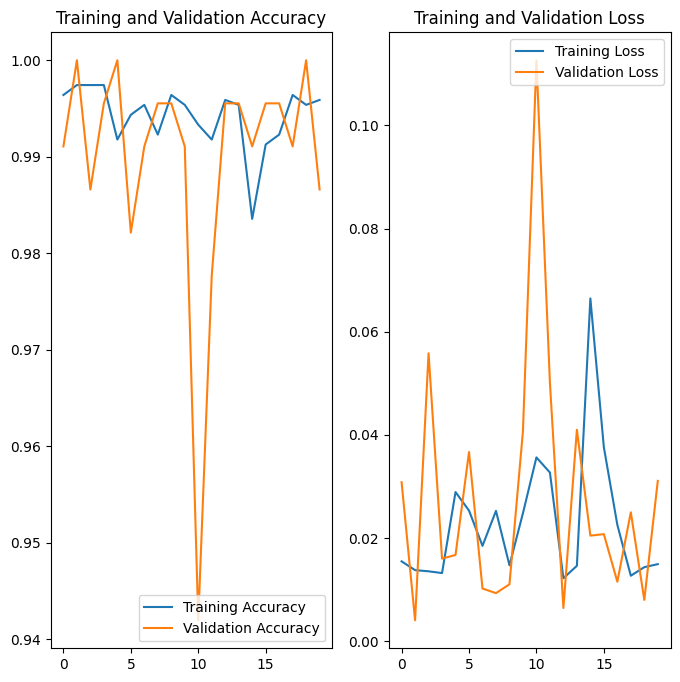

In [142]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Pepper__bell___healthy
1/1 [==============================] - 0s 392ms/step
predicted label: Pepper__bell___Bacterial_spot


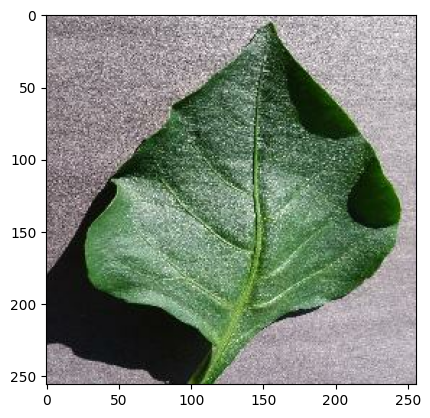

In [172]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[15].numpy().astype('uint8')
    first_label = labels_batch[15].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [163]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 152ms/step


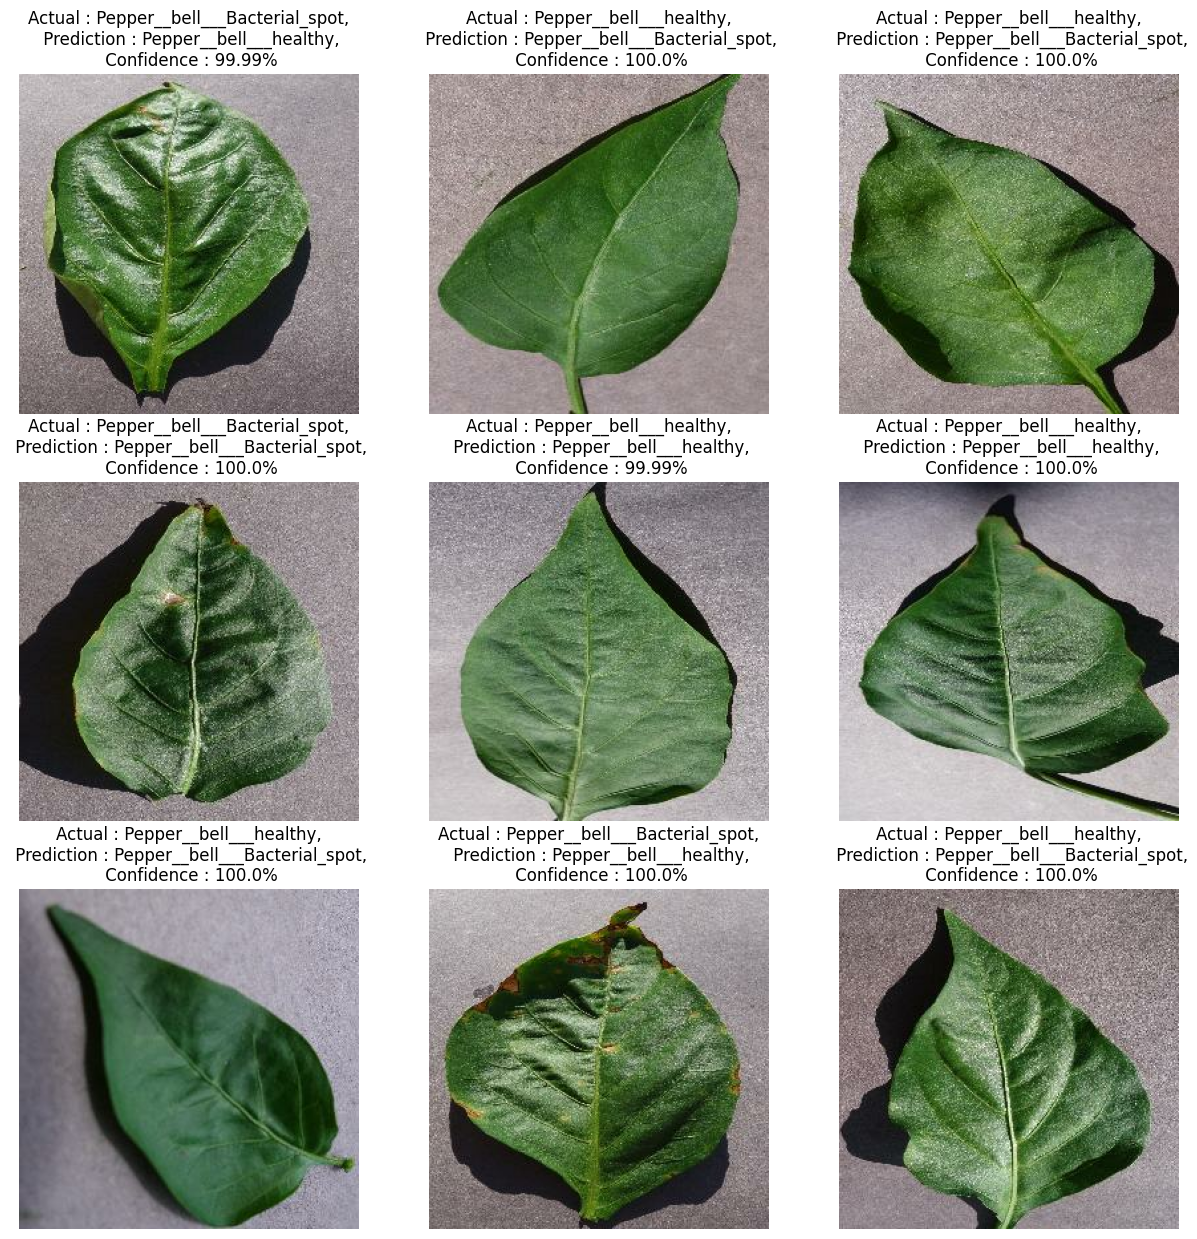

In [160]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
        label = class_names[labels[i]]
        batch_prediction = model.predict(images_batch)
        predicted_class = class_names[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')
    
        plt.axis('off')

In [149]:
import os
model_version=max([int(i) for i in os.listdir("/UCordoba/Machine Learning/PlantVillage/Pepper/models/") + [0]])+1
model.save(f"/UCordoba/Machine Learning/PlantVillage/Pepper/models/{model_version}")


INFO:tensorflow:Assets written to: /UCordoba/Machine Learning/PlantVillage/Pepper/models/2\assets


INFO:tensorflow:Assets written to: /UCordoba/Machine Learning/PlantVillage/Pepper/models/2\assets


In [150]:
model.save("../Peppers.h5")


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [151]:
model.save("/UCordoba/Machine Learning/PlantVillage/Pepper/Peppers.h5")